## Weekly Greenhouse Gas Estimation

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

import datetime 

### Dynamic Data: Weekly GDP tracker

Weekly Updated GDP change estimate by OECD: https://www.oecd.org/economy/weekly-tracker-of-gdp-growth/

The variable **Change** is defined as the percent change of last week's GDP compared to the same week of the pre-pandemic year. It is conceptually equivalent to the following, although actual calculation is a bit more complicated:

\begin{align*}
y_{i,0} &= \textrm{Weekly GDP of the week i of THIS year, measured at PRE-pandemic price level}\\
y_{i,pre} &= \textrm{Weekly GDP of the week i of PRE-pandemic year}\\
\textrm{Change} &= \frac{y_{i,} - y_{i,pre}}{y_{i,pre}} \quad (\textrm{in percentage})
\end{align*}

Under the hood, the OECD tracker is trained with the real-GDP changes, and thus it returns the real change, not the nominal change.

In [2]:
dynamic_data_link = \
    "https://github.com/NicolasWoloszko/OECD-Weekly-Tracker/raw/main/Data/weekly_tracker.xlsx"
df_weekly_raw = pd.read_excel(dynamic_data_link)

Here are the list of countries being tracked and estimated. However, the frequency of the tracking is not the same for all countries. 

In [3]:
df_weekly_raw['region'].unique()

array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil',
       'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia',
       'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'United Kingdom', 'United States'],
      dtype=object)

A helper function to return the `n_sundays` number of date strings of the beginning of the most recent weeks for which the data is available. 

In [4]:
def get_past_n_sundays(n_sundays = 3):
    date_today = datetime.datetime.now() 

    days_delta_list =  [1 + 7*(i+1) for i in range(n_sundays)]

    date_sunday_list = [(date_today - 
                         datetime.timedelta(
                             days = (each_delta + date_today.weekday())
                         )
                        )
                        for each_delta 
                        in days_delta_list]

    sunday_string_list = [each_sunday.strftime("%Y-%m-%d") 
                          for each_sunday 
                          in date_sunday_list]

    return sunday_string_list

In [5]:
get_past_n_sundays(n_sundays = 2)

['2021-11-14', '2021-11-07']

We have to filter only the relevant portion of the original raw excel file, which is huge.

In [6]:
# G7 countries
countries_g7 = ['Canada', 'France', 'Germany','Italy',
             'Japan','United Kingdom','United States']

weeks = get_past_n_sundays(n_sundays = 2)

In [7]:
def dynamic_data_filter(countries_list, weeks_list):
    df_weekly = df_weekly_raw[['region', 'date', 'Tracker (yo2y)']].copy()
    df_weekly = df_weekly.rename(columns = {"region": "Country", 
                                            "date": "Week", 
                                            "Tracker (yo2y)": "GDP_Change"})
    
    df_weekly = df_weekly[df_weekly["Week"] > '2021-10-01']
    df_weekly["Week"] = df_weekly["Week"].astype(str)
    
    df_weekly = df_weekly[df_weekly["Country"].apply(lambda x: x in countries_list)]
    df_weekly = df_weekly[df_weekly["Week"].apply(lambda x: x in weeks_list)]

    df_weekly = df_weekly.reset_index(drop = True)

    return df_weekly

In [8]:
dynamic_data_filter(countries_g7, weeks)

,Country,Week,GDP_Change
0,Canada,2021-11-07,1.459476
1,Canada,2021-11-14,2.213901
2,France,2021-11-07,1.702749
3,France,2021-11-14,2.061052
4,Germany,2021-11-07,-0.821308
5,Germany,2021-11-14,-0.771931
6,Italy,2021-11-07,-0.100860
7,Italy,2021-11-14,-2.139592
8,Japan,2021-11-07,-0.667064
9,Japan,2021-11-14,0.970763


### Static Data 1: Greenhouse Gas

The collected data on greenhouse gas emission is in the unit of CO2 equivalent tonnes during the years from 2015 to 2019, which are the past five years prior to the pandemic. The data is from the OECD: https://stats.oecd.org/Index.aspx?DataSetCode=AIR_GHG

Ideally, we would like to use the values over many years to remove random fluctuations. However, the data from too many years ago would not be relevant. We thought the past five pre-pandemic years would be a good trade-off.

In [9]:
countries_g7

['Canada',
 'France',
 'Germany',
 'Italy',
 'Japan',
 'United Kingdom',
 'United States']

In [10]:
df_ghg_raw = pd.read_csv("../data/AIR_GHG_25112021005547428.csv")

In [11]:
def ghg_filter(countries_list):
    years = [2015, 2016, 2017, 2018, 2019]
    df_ghg = df_ghg_raw.copy()
    df_ghg = df_ghg[df_ghg["Variable"] == 'Total  emissions excluding LULUCF']
    df_ghg = df_ghg[df_ghg["Unit"] == 'Tonnes of CO2 equivalent']
    df_ghg = df_ghg[df_ghg["Pollutant"] == 'Greenhouse gases']
    df_ghg = df_ghg[df_ghg["Year"].apply(lambda x: x in years)]
    df_ghg = df_ghg[df_ghg["Country"].apply(lambda x: x in countries_list)]

    df_ghg = df_ghg[["Country", "Year", "Value"]]

    df_ghg = df_ghg.rename(columns = {"Value":"GHG"})

    df_ghg = df_ghg.reset_index(drop = True)
    
    return df_ghg

In [12]:
ghg_filter(countries_g7)

,Country,Year,GHG
0,Canada,2015,723096.018
1,Canada,2016,706933.908
2,Canada,2017,716092.013
3,Canada,2018,728475.890
4,Canada,2019,730244.943
5,France,2015,464205.673
6,France,2016,467059.995
7,France,2017,470564.316
8,France,2018,452034.456
9,France,2019,442984.668


### Static Data 2: Gross Domestic Product

The real GDP for each countries during the same set of years is collected. The data is from the IMF: https://www.imf.org/external/datamapper/NGDPD@WEO/OEMDC/ADVEC/WEOWORLD

This is an inflation-adjusted measure of GDP, which is different from non-adjusted measure of nominal GDP.

![IMF real GDP graph](<../figures/exp-2021-11-26_21 38 08.png>)

In [13]:
df_gdp_raw = pd.read_excel("../data/imf real gdp.xlsx")

In [14]:
def gdp_filter(countries_list):
    years = [2015, 2016, 2017, 2018, 2019]
    
    df_gdp = pd.melt(df_gdp_raw, 
                     id_vars = 'GDP, current prices (Billions of U.S. dollars)', 
                     var_name = "Year",
                     value_name = "GDP")
    
    df_gdp = df_gdp.rename(columns = {'GDP, current prices (Billions of U.S. dollars)':"Country"})

    df_gdp = df_gdp[df_gdp["Year"].apply(lambda x: x in years)]
    df_gdp = df_gdp[df_gdp["Country"].apply(lambda x: x in countries_list)]
    df_gdp["GDP"] = df_gdp["GDP"].astype(float)

    df_gdp = df_gdp.reset_index(drop = True)
    
    return df_gdp

### Static Model: GH Gas vs. GDP

Here is a model that predicts the greenhouse gas emission from the GDP for each country. 

#### Static Model Data

In [15]:
countries_g7

['Canada',
 'France',
 'Germany',
 'Italy',
 'Japan',
 'United Kingdom',
 'United States']

In [16]:
df_static = ghg_filter(countries_g7)
df_static = df_static.sort_values(by = ["Country", "Year"], 
                                  ignore_index = True)
df_gdp = gdp_filter(countries_g7)
df_gdp = df_gdp.sort_values(by = ["Country", "Year"], 
                            ignore_index = True)
#display(pd.concat([df_static, df_gdp], axis = 1))
df_static["GDP"] = df_gdp["GDP"]
df_static

,Country,Year,GHG,GDP
0,Canada,2015,723096.018,1556.508
1,Canada,2016,706933.908,1527.996
2,Canada,2017,716092.013,1649.266
3,Canada,2018,728475.890,1721.822
4,Canada,2019,730244.943,1741.576
5,France,2015,464205.673,2438.208
6,France,2016,467059.995,2471.261
7,France,2017,470564.316,2589.031
8,France,2018,452034.456,2789.680
9,France,2019,442984.668,2728.834


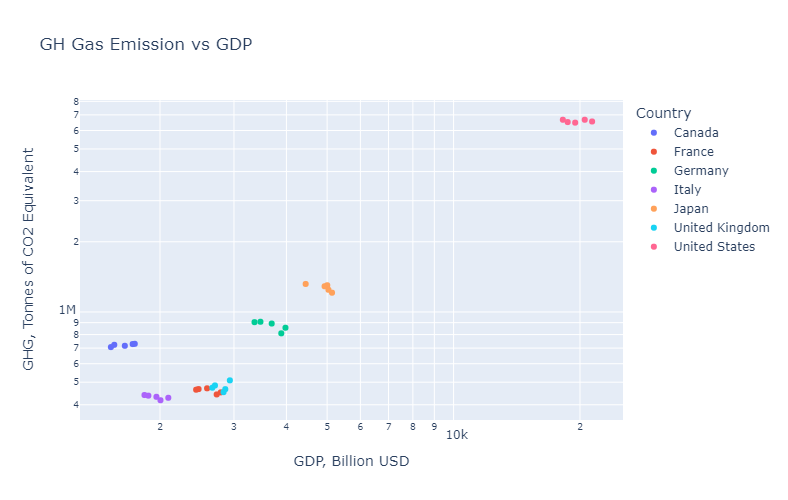

In [30]:
fig01 = px.scatter(df_static, 
                   x = "GDP", 
                   y = "GHG", 
                   color = "Country",
                   hover_data = ["Year"], 
                   log_x = True, 
                   log_y = True,
                   title = "GH Gas Emission vs GDP",
                   labels={'GDP':'GDP, Billion USD', 
                           'GHG':'GHG, Tonnes of CO2 Equivalent'},
                   height = 500,
                   width = 700
                  )
fig01.show()

#### Static Model Fitting

In [18]:
df_static["log(GHG)"] = np.log(df_static["GHG"])
df_static["log(GDP)"] = np.log(df_static["GDP"])

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
each_country = 'Canada'
df_linreg = df_static[df_static["Country"] == each_country]

In [21]:
coef_list = []
for each_country in countries_g7:
    df_linreg = df_static[df_static["Country"] == each_country]

    y = df_linreg["log(GHG)"].to_numpy()
    X = df_linreg["log(GDP)"].to_numpy()
    
    X = X[:, np.newaxis]
    
    linreg = LinearRegression()
    linreg.fit(X, y)
    linreg.coef_
    
    coef_list.append(linreg.coef_[0])

In [22]:
coef_list

[0.17989018168755153,
 -0.32148987241070526,
 -0.532405973950238,
 -0.2862370671505205,
 -0.45534032614830783,
 0.2788329490702167,
 -0.00811169697189959]

#### Static Model Prediction Function

In [23]:
df_predict = df_static[df_static["Year"] == 2019]
df_predict = df_predict[["Country", "GHG"]]
df_predict["coef"] = np.array(coef_list)
df_predict = df_predict.set_index(keys = "Country")
df_predict

,GHG,coef
Country,,
Canada,730244.943,0.179890
France,442984.668,-0.321490
Germany,809798.537,-0.532406
Italy,418280.596,-0.286237
Japan,1209493.354,-0.455340
United Kingdom,453101.458,0.278833
United States,6558345.179,-0.008112


In [24]:
def predict_weekly_emission(country_name, change):
    amount = df_predict.loc[country_name, "GHG"]
    amount_week = amount*7/365

    change_gh = change*df_predict.loc[country_name, "coef"]

    amount_week = amount_week*(1 + change_gh/100)
    
    return amount_week, change_gh

In [25]:
predict_weekly_emission("France", 5.6)

(8342.64647374541, -1.8003432854999493)

### Dynamic Prediction 

In [26]:
df_weekly = dynamic_data_filter(countries_g7, get_past_n_sundays())
df_weekly["GHG_weekly"] = 0
df_weekly["GHG_Change"] = 0

for index, row in df_weekly.iterrows():
    amount_week, change_gh = predict_weekly_emission(row["Country"],
                                                     row["GDP_Change"])
    df_weekly.loc[index, "GHG_weekly"] = amount_week
    df_weekly.loc[index, "GHG_Change"] = change_gh

In [27]:
df_weekly

,Country,Week,GDP_Change,GHG_weekly,GHG_Change
0,Canada,2021-10-31,1.744943,14048.658014,0.313898
1,Canada,2021-11-07,1.459476,14041.466228,0.262545
2,Canada,2021-11-14,2.213901,14060.472505,0.398259
3,France,2021-10-31,2.720064,8421.304668,-0.874473
4,France,2021-11-07,1.702749,8449.090066,-0.547417
5,France,2021-11-14,2.061052,8439.303927,-0.662607
6,Germany,2021-10-31,-0.138315,15541.819448,0.073640
7,Germany,2021-11-07,-0.821308,15598.292497,0.437269
8,Germany,2021-11-14,-0.771931,15594.209771,0.410981
9,Italy,2021-10-31,0.812233,8003.169623,-0.232491


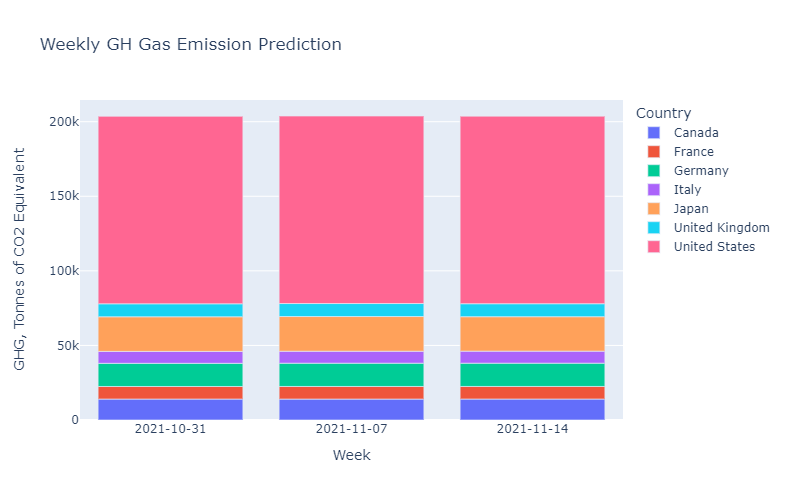

In [31]:
fig02 = px.bar(df_weekly, 
               x = "Week", 
               y = "GHG_weekly", 
               color = "Country",
               title = "Weekly GH Gas Emission Prediction", 
               labels={'GHG_weekly':'GHG, Tonnes of CO2 Equivalent'},
               width = 700,
               height = 500
              )

fig02.update_layout(xaxis_type='category')

fig02.show()

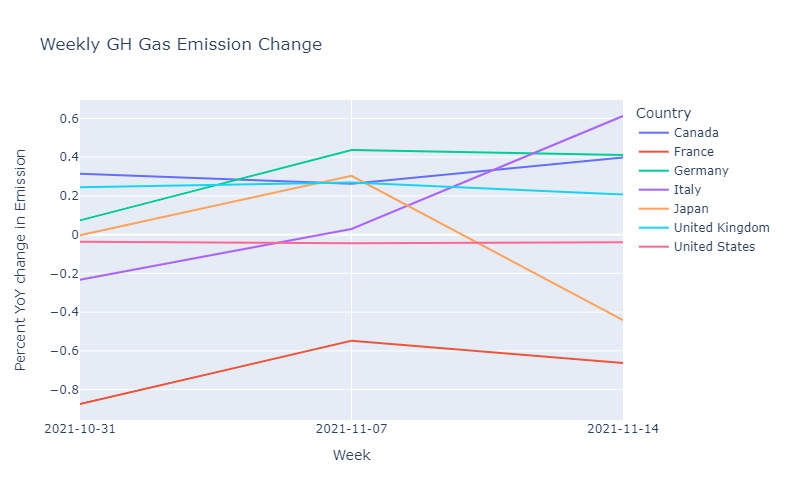

In [32]:
fig03 = px.line(df_weekly, 
               x = "Week", 
               y = "GHG_Change", 
               color = "Country",
               title = "Weekly GH Gas Emission Change", 
               labels={'GHG_Change':'Percent YoY change in Emission'},
               width = 700,
               height = 500
              )

fig03.update_layout(xaxis_type='category')

fig03.show()